In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('../../')
import tokamakTK
from tokamakTK import get_ECT_regression, HUEOrder, get_pi_matrix, clean_numerical_data, MyCounter

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from PIL import Image
#import imageio
import imageio.v2 as imageio
from matplotlib.lines import Line2D
from PIL import Image
import os
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import scipy as sp
import statsmodels.api as sm
import matplotlib.patches as mpatches
import matplotlib.colors as mcolors
import seaborn as sns
import plotly.express as px
import plotly.subplots as plsp
import plotly.graph_objects as go
from plotly.subplots import make_subplots

from collections import Counter

pd.set_option('display.max_columns', None)
plt.rc('font',family = 'serif')
path = "../../data/"
fig_path = "../../../../LATEX/Latex Images/"

coeffs = ['IP', 'BT', 'NEL', 'PLTH', 'RGEO', 'KAREA', 'EPS', 'MEFF']

In [3]:
# Obtained from Optimization

min_subset_ids_6357 = pd.read_csv(path+"R_ids_alpha_0.6357.csv")
min_subset_ids_9998 = pd.read_csv(path+"R_ids_alpha_0.9998.csv")
min_subset_ids_joe  = pd.read_csv(path+"deviation_id.csv")

DB2 = pd.read_csv(path+"DB2P8.csv")
DB5 = pd.read_csv(path+"SELDB5_SVD.csv", low_memory=False) 

# Setting ELMy Dataset
DB5 = DB5[DB5["PHASE"].isin(['HGELM', 'HSELM', 'HGELMH', 'HSELMH'])]

# Removing Spherical TOKAMAKS
#DB5 = DB5[~DB5["TOK"].isin(['START','MAST','NSTX'])]

# There is two shots from DB2P8 missing in DB5
missing_shots = DB2[~DB2.id.isin( DB5.id.values )].reset_index(drop=True)
DB5 = pd.concat([DB5, missing_shots], axis=0, ignore_index=True)

# Labeling shots that had great impact in decreasing alpha_R
DB5.insert(loc=2,column="label_6357",value=["Unaffected"]*len(DB5))
DB5.loc[(DB5[DB5.id.isin(min_subset_ids_6357.id)].index), "label_6357"] = "Decreasing"

DB5.insert(loc=2,column="label_9998",value=["Unaffected"]*len(DB5))
DB5.loc[(DB5[DB5.id.isin(min_subset_ids_9998.id)].index), "label_9998"] = "Decreasing"

DB5.insert(loc=2,column="label_joe",value=["Unaffected"]*len(DB5))
DB5.loc[(DB5[DB5.id.isin(min_subset_ids_joe.id)].index), "label_joe"] = "Decreasing"

DB5.insert(loc=2,column="Spherical",value=["No Spherical"]*len(DB5))
DB5.loc[(DB5[DB5.TOK.isin(['START','MAST','NSTX'])].index), "Spherical"] = "Spherical"

DB5.insert(0, 'intercept', np.ones(len(DB5)))


print(
    "  Subset that decrease alpha-R to 0.6357\n--------\n" +
    f"{ round( (len(min_subset_ids_6357)/len(DB5))*100     ,2)  }% affected alpha_R\n" + 
    f"{ round( (1 - len(min_subset_ids_6357)/len(DB5))*100 ,2)  }% did not affect alpha_R" +
    "\n\n\n  Subset that decrease alpha-R to 0.9998\n--------\n" +
    f"{ round( (len(min_subset_ids_9998)/len(DB5))*100     ,2)  }% affected alpha_R\n" + 
    f"{ round( (1 - len(min_subset_ids_9998)/len(DB5))*100 ,2)  }% did not affect alpha_R"
    "\n\n\n  Subset given by Joseph Hall           \n--------\n" +
    f"{ round( (len(min_subset_ids_joe)/len(DB5))*100     ,2)  }% affected alpha_R\n" + 
    f"{ round( (1 - len(min_subset_ids_joe)/len(DB5))*100 ,2)  }% did not affect alpha_R"
)

DB5 = tokamakTK.clean_categorical_data(DB5)

  Subset that decrease alpha-R to 0.6357
--------
23.45% affected alpha_R
76.55% did not affect alpha_R


  Subset that decrease alpha-R to 0.9998
--------
9.88% affected alpha_R
90.12% did not affect alpha_R


  Subset given by Joseph Hall           
--------
18.46% affected alpha_R
81.54% did not affect alpha_R


In [4]:
def get_HUEORDER(DB5):
    DB5 = tokamakTK.clean_categorical_data(DB5)
    # Needed for Improved Visualization: 2D and 3D Plots
    HUE_ORDER, PX_ORDER = tokamakTK.get_colors_per_category(DB5)
    hue_order = HUEOrder(HUE_ORDER)

    # ---------------------------------------------------

    # SPECIAL PARAMETERS
    colors_ = sns.color_palette('tab20', 20)
    HUE_ORDER["Spherical"] = dict(zip(sorted(DB5["Spherical"].unique()), colors_[:len(DB5["Spherical"].unique())]))
    HUE_ORDER["label_joe"] = dict(zip(sorted(DB5["label_joe"].unique()), colors_[:len(DB5["label_joe"].unique())]))
    HUE_ORDER["TOK"]["START"] = (0.8235, 0.5055, 0.4412)
    
    return HUE_ORDER, PX_ORDER

HUE_ORDER, PX_ORDER = get_HUEORDER(DB5)

In [5]:
data1 = DB5[DB5.label_6357.isin(["Decreasing"])].reset_index(drop=True)
data2 = DB5[DB5.label_6357.isin(["Unaffected"])].reset_index(drop=True)
data2 = data2[~data2.id.isin(DB2.id.values)].reset_index(drop=True)

data = [data1,data2]

In [247]:
import pdb # For debugging || pdb.set_trace()

def get_twods3D_plot_DB5(db5, data, rotation, 
                         saveFig=False, file_name="", remSPH=False):
    
    
    db5_  = db5.copy()
    min_alphaR_id = data[0].id.values
    max_alphaR_id = data[1].id.values
    
    db5_.loc[db5_.index, "color_min"] = "k"
    db5_.loc[db5_.index, "color_max"] = "k"
    
    db5_.loc[ db5_[db5_.id.isin(min_alphaR_id)].index, "color_min" ] = "red"
    db5_.loc[ db5_[db5_.id.isin(max_alphaR_id)].index, "color_max" ] = "red"
    
    x, y, z = "NUSTAR", "RHOSTAR", "Q95"
    #x, y, z =  "RHOSTAR", "Q95", "TAUTH"
    
    y_sp = (11, 20, 12)
    if remSPH:
        db5_ = db5_[~db5_.TOK.isin(['START','MAST','NSTX'])]
        y_sp = (11, 25, 11)
    
    fig = plt.figure(figsize=(13, 4.5))
    ax1 = fig.add_subplot(121, projection='3d')
    ax2 = fig.add_subplot(122, projection='3d')
    
    # Adjust subplot positions
    fig.subplots_adjust(wspace=0.05)
    
    
    scatter = ax1.scatter(db5_[x], db5_[y], db5_[z], c=db5_["color_min"].values)
    ax1.set_xlabel(x, fontsize=11, labelpad=11)
    ax1.set_ylabel(y, fontsize=y_sp[0], labelpad=y_sp[1])
    ax1.set_zlabel(z, fontsize=11, rotation=90)  
    ax1.tick_params(axis='x', labelsize=12)
    ax1.tick_params(axis='y', labelsize=y_sp[2])
    ax1.tick_params(axis='z', labelsize=12)
    
    """ax1.set_xticks(ax1.get_xticks())
    ax1.set_xticklabels(ax1.get_xticks(), rotation= -10)"""
    
    ax1.set_yticks(ax1.get_yticks())
    ax1.set_yticklabels(ax1.get_yticks(), rotation=90)
    ax1.view_init(elev=15, azim=rotation)


    # GETTING THE SECOND PLOT
    scatter = ax2.scatter(db5_[x], db5_[y], db5_[z], c=db5_["color_max"].values)
    ax2.set_xlabel(x, fontsize=11, labelpad=11)
    ax2.set_ylabel(y, fontsize=y_sp[0], labelpad=y_sp[1])
    ax2.zaxis.set_label_text(z, fontsize=11, rotation=90)  
    ax2.tick_params(axis='x', labelsize=12)
    ax2.tick_params(axis='y', labelsize=y_sp[2])
    ax2.tick_params(axis='z', labelsize=12)
    
    """ax2.set_xticks(ax2.get_xticks())
    ax2.set_xticklabels(ax2.get_xticks(), rotation= -10)"""
    
    ax2.set_yticks(ax2.get_yticks())
    ax2.set_yticklabels(ax2.get_yticks(), rotation=90)
    ax2.view_init(elev=15, azim=rotation)
    
    
    ax1.annotate("$\\tau_{E,0.64}$", xy=(0.09, 0.86), xycoords='axes fraction',
                 fontsize=16, color="red")
    ax2.annotate("$\\tau_{E,0.99}$", xy=(0.74, 0.86), xycoords='axes fraction',
                 fontsize=16, color="red")
    
    colors_dict = {"Decreasing":"red", "Unaffected":"black"}
    legend_elements = []
    for category, color in colors_dict.items():
            legend_elements.append(plt.Line2D([1], [1], marker='o', 
                                   color='w', label=category, markerfacecolor=color, markersize=7))
    legend = ax1.legend(handles=legend_elements, frameon=False,
                 loc='upper right', bbox_to_anchor=(1.43, 0.9), fontsize=10)

    
    if saveFig:
        #plt.savefig(path + file_name, format="png")
        plt.savefig(path + file_name, format="pdf", dpi=800)
        plt.close()

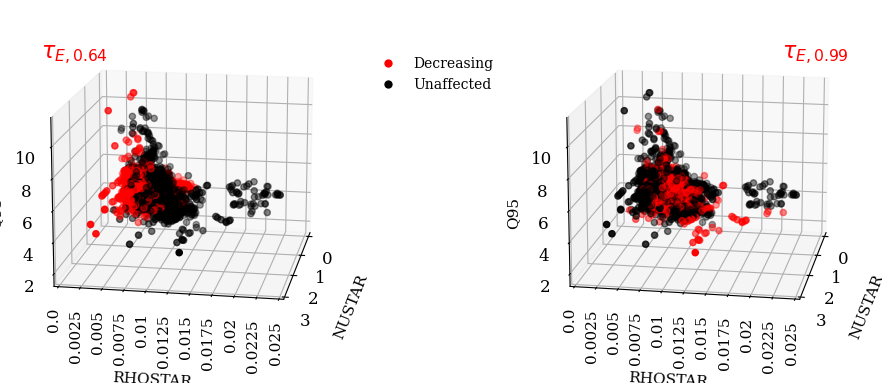

In [250]:
get_twods3D_plot_DB5(DB5, data, 10, saveFig=False, file_name="test", remSPH=True)

# ROTATION

```Python
for r in np.linspace(0,360, 360//2):
    file_name = f"GIF_images/image_{int(r)}.png"
    get_twods3D_plot_DB5(DB5, data, int(r), saveFig=True, file_name=file_name, remSPH=False)
    
x, y, z = "NUSTAR", "RHOSTAR", "Q95"

image_folder = path+"GIF_images/"  # Path to the folder containing the images
output_file = path+"/GIFs/"+f"roCo{x[0]}{y[0]}{z[0]}.gif"  # Output file name

# Get a list of PNG files in the folder
image_files = [os.path.join(image_folder, file) for file in os.listdir(image_folder) if file.endswith('.png')]
# Sort the image files by their numerical values in the filenames
image_files.sort(key=lambda x: int(os.path.splitext(os.path.basename(x))[0].split('_')[-1]))

# Save the images in the folder as an animated GIF
imageio.mimsave(output_file, [imageio.imread(file) for file in image_files], fps=7)
```

# Dynamic Plots

In [173]:
# amount: images that the gif will contain
amount = 360

small_dataset = pd.read_csv(path+"decreased_dataset_random_sampling_500_decreasing_points.csv")
samples = [f"subset_{int(i)}" for i in np.linspace(1,len(small_dataset.columns)-1,amount)]
values = small_dataset[samples].describe().loc["min"]
indxs = [small_dataset[small_dataset[values.keys()[i]].isin([values.values[i]])].index[0] for i in range(amount)]

info = pd.DataFrame([np.linspace(1,len(small_dataset.columns)-1,amount),small_dataset.loc[indxs]["seed"].values]).T
info = info.rename(columns={0:"sampling", 1:"seed"})
info["sampling"] = info["sampling"].astype(int)
info["seed"] = info["seed"].astype(int)

In [174]:
DB5_decreas_pts = pd.read_csv(path+"decreasing_dataset_info.csv")
# Sampling on the decreasing points of the decreasing DS
#    If sampling is on "decreased": sampling on decreasing points in decreasing dataset (smaller alpha_R)
#    If sampling is on "weights": sampling on complete dataset only (highers alpha_R)
IDs = [
    DB5_decreas_pts.sample(n=info["sampling"][i], 
                           weights='decreased', 
                           random_state=info["seed"][i]) for i in range(amount)
]
    
# Adding mine with alpha_R of approx 0.63
IDs = IDs + [min_subset_ids_6357]

In [175]:
# Also serves as sanity check
# ----------------------------------------
DF = [DB5[DB5.id.isin(IDs[i].id.values) | DB5.id.isin(DB2.id.values)] for i in range(amount+1)]
ALPHAs = [get_ECT_regression(DF[i]).params["RGEO"] for i in range(len(DF))]

In [245]:
import pdb # For debugging || pdb.set_trace()

def get_twods3D_DynROT(db5, rotation, indxs,
                         saveFig=False, file_name="", remSPH=False):
    
    
    db5_  = db5.copy()
    
    db5_.loc[db5_.index, "colors"] = "k"
    db5_.loc[ db5_[db5_.id.isin(indxs.id.values)].index, "colors" ] = "red"
    
    alpha = round(
        get_ECT_regression(
            db5_[db5_.id.isin(DB2.id.values) | db5_.id.isin(indxs.id.values)]
        ).params["RGEO"], 2
    )
    
    x, y, z = "NUSTAR", "RHOSTAR", "Q95"
    #x, y, z =  "RHOSTAR", "Q95", "TAUTH"
    
    y_sp = (11, 20, 12)
    if remSPH:
        db5_ = db5_[~db5_.TOK.isin(['START','MAST','NSTX'])]
        y_sp = (11, 25, 11)
    
    fig = plt.figure(figsize=(13, 4.5))
    ax1 = fig.add_subplot(121, projection='3d')
    ax2 = fig.add_subplot(122, projection='3d')
    
    # Adjust subplot positions
    fig.subplots_adjust(wspace=0.05)
    
    
    scatter = ax1.scatter(db5_[x], db5_[y], db5_[z], c=db5_["colors"].values)
    ax1.set_xlabel(x, fontsize=11, labelpad=11)
    ax1.set_ylabel(y, fontsize=y_sp[0], labelpad=y_sp[1])
    ax1.set_zlabel(z, fontsize=11, rotation=90)  
    ax1.tick_params(axis='x', labelsize=12)
    ax1.tick_params(axis='y', labelsize=y_sp[2])
    ax1.tick_params(axis='z', labelsize=12)
    
    """ax1.set_xticks(ax1.get_xticks())
    ax1.set_xticklabels(ax1.get_xticks(), rotation= -10)"""
    
    ax1.set_yticks(ax1.get_yticks())
    ax1.set_yticklabels(ax1.get_yticks(), rotation=90)
    ax1.view_init(elev=15, azim=rotation)


    # GETTING THE SECOND PLOT
    scatter = ax2.scatter(db5_[x], db5_[y], db5_[z], c=db5_["colors"].values)
    ax2.set_xlabel(x, fontsize=11, labelpad=11)
    ax2.set_ylabel(y, fontsize=y_sp[0], labelpad=y_sp[1])
    ax2.zaxis.set_label_text(z, fontsize=11, rotation=90)  
    ax2.tick_params(axis='x', labelsize=12)
    ax2.tick_params(axis='y', labelsize=y_sp[2])
    ax2.tick_params(axis='z', labelsize=12)
    
    """ax2.set_xticks(ax2.get_xticks())
    ax2.set_xticklabels(ax2.get_xticks(), rotation= -10)"""
    
    ax2.set_yticks(ax2.get_yticks())
    ax2.set_yticklabels(ax2.get_yticks(), rotation=90)
    ax2.view_init(elev=15, azim=10)
    
    
    colors_dict = {"Decreasing":"red", "Unaffected":"black"}
    legend_elements = []
    for category, color in colors_dict.items():
            legend_elements.append(plt.Line2D([1], [1], marker='o', 
                                   color='w', label=category, markerfacecolor=color, markersize=7))
    legend = ax1.legend(handles=legend_elements, frameon=False,
                 loc='upper right', bbox_to_anchor=(1.43, 0.9), fontsize=10)
    
    ax1.annotate(f"$\\alpha_R \\sim {alpha}$", xy=(1.1, 0.9), xycoords='axes fraction',
                 fontsize=15, color="red")

    
    if saveFig:
        plt.savefig(path + file_name, format="png")
        #plt.savefig(path + file_name, format="pdf", dpi=800)
        plt.close()

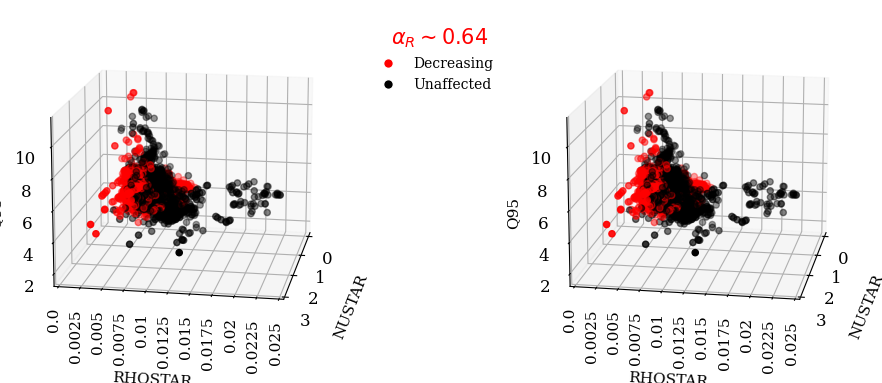

In [246]:
get_twods3D_DynROT(DB5, 10, IDs[-1], saveFig=False, file_name="", remSPH=True)

In [243]:
for r in np.linspace(0,360, 360//2):
    file_name = f"GIF_images/image_{int(r)}.png"
    get_twods3D_DynROT(DB5, int(r), IDs[int(r)], saveFig=True, file_name=file_name, remSPH=True)

In [244]:
x, y, z = "NUSTAR", "RHOSTAR", "Q95"

image_folder = path+"GIF_images/"  # Path to the folder containing the images
output_file = path+"/GIFs/"+f"roDyn{x[0]}{y[0]}{z[0]}_noSPHE.gif"  # Output file name

# Get a list of PNG files in the folder
image_files = [os.path.join(image_folder, file) for file in os.listdir(image_folder) if file.endswith('.png')]
# Sort the image files by their numerical values in the filenames
image_files.sort(key=lambda x: int(os.path.splitext(os.path.basename(x))[0].split('_')[-1]))

# Save the images in the folder as an animated GIF
imageio.mimsave(output_file, [imageio.imread(file) for file in image_files], fps=7)

## For Rotation and Dynamic Change

```Python
for r in np.linspace(0,360, 360//2):
    file_name = f"GIF_images/image_{int(r)}.png"
    get_3D_gif_DB5_label(DB5, int(r), IDs[int(r)], saveFig=True, file_name=file_name)

x,y,z = "NUSTAR", "RHOSTAR", "Q95"

image_folder = path+"GIF_images/"  # Path to the folder containing the images
output_file = f'ROTATION_in_{x}_{y}_{z}.gif'  # Output file name

# Get a list of PNG files in the folder
image_files = [os.path.join(image_folder, file) for file in os.listdir(image_folder) if file.endswith('.png')]
# Sort the image files by their numerical values in the filenames
image_files.sort(key=lambda x: int(os.path.splitext(os.path.basename(x))[0].split('_')[-1]))

# Save the images in the folder as an animated GIF
imageio.mimsave(output_file, [imageio.imread(file) for file in image_files], fps=7)
```

In [32]:
def get_3D_plot_DB5_tauth(db5, indxs, saveFig=False, file_name="", remSPH=False):
    # Create a figure and a 3D axis
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    alpha = round(
        get_ECT_regression(
            DB5[DB5.id.isin(DB2.id.values) | DB5.id.isin(indxs.id.values)]
        ).params["RGEO"], 2
    )
    
    data = db5.copy()
    x, y, z = "NUSTAR", "RHOSTAR", "Q95"
    
    y_sp = (11, 20, 13)
    if remSPH:
        data = data[~data.TOK.isin(['START','MAST','NSTX'])]
        y_sp = (11, 25, 11)
        
    
    # Plot the data points with color based on "TAUTH"
    scatter = ax.scatter(data[x], data[y], data[z], c=data["TAUTH"], 
                         cmap="CMRmap")
    ax.set_xlabel(x, fontsize=11, labelpad=7)
    ax.set_ylabel(y, fontsize=y_sp[0], labelpad=y_sp[1])
    ax.set_zlabel(z+"\n", fontsize=11, rotation=90)  
    ax.tick_params(axis='x', labelsize=13)
    ax.tick_params(axis='y', labelsize=y_sp[2])
    ax.tick_params(axis='z', labelsize=13)
    
    #ax.set_title("STDB5 without Spherical Tokamaks")
    
    ax.set_yticks(ax.get_yticks())
    ax.set_yticklabels(ax.get_yticks(), rotation=45)
    
    # Add a color bar
    cbar = fig.colorbar(scatter, ax=ax, shrink=0.65, aspect=27, pad=0.03)
    cbar.set_label("\nEnergy Conginement Time [s]", fontsize=13.6)
    cbar.ax.tick_params(labelsize=13)

    
    ax.view_init(elev=15, azim=175)
    
    if saveFig:
        #plt.savefig(path + file_name)
        plt.savefig(path + file_name, format="pdf", dpi=800)
        plt.close()


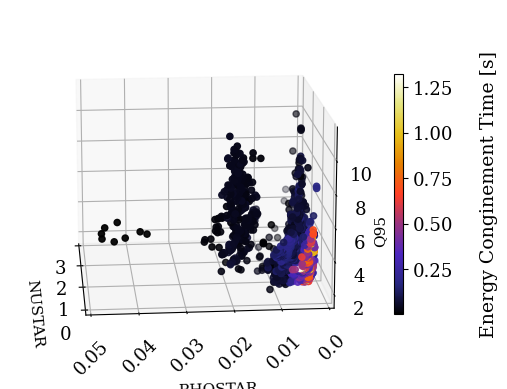

In [33]:
get_3D_plot_DB5_tauth(DB5, min_subset_ids_6357, saveFig=False, file_name="test_tauth.pdf", remSPH=False)

In [ ]:
def get_3D_plot_DB5_TOK(db5, indxs, saveFig=False, file_name="", remSPH=False):
    # Create a figure and a 3D axis
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    alpha = round(
        get_ECT_regression(
            DB5[DB5.id.isin(DB2.id.values) | DB5.id.isin(indxs.id.values)]
        ).params["RGEO"], 2
    )
    
    data = db5.copy()
    x, y, z = "NUSTAR", "RHOSTAR", "Q95"
    
    y_sp = (11, 20, 13)
    if remSPH:
        data = data[~data.TOK.isin(['START','MAST','NSTX'])]
        y_sp = (11, 25, 11)
        HUE_ORDER["TOK"].pop('START')
        HUE_ORDER["TOK"].pop('MAST')
        HUE_ORDER["TOK"].pop('NSTX')
        print("Remember to re-run HUE_ORDER")
    
    data["colors"] = data["TOK"].map(HUE_ORDER["TOK"])
    
    # Plot the data points with color based on "TAUTH"
    scatter = ax.scatter(data[x], data[y], data[z], c=data["colors"].values)
    ax.set_xlabel(x, fontsize=11, labelpad=7)
    ax.set_ylabel(y, fontsize=y_sp[0], labelpad=y_sp[1])
    ax.set_zlabel(z, fontsize=11, rotation=90)  
    ax.tick_params(axis='x', labelsize=13)
    ax.tick_params(axis='y', labelsize=y_sp[2])
    ax.tick_params(axis='z', labelsize=13)
    
    #ax.set_title("STDB5 without Spherical Tokamaks")
    
    ax.set_yticks(ax.get_yticks())
    ax.set_yticklabels(ax.get_yticks(), rotation=45)
    
    # Add a legend
    legend_elements = []
    for category, color in HUE_ORDER["TOK"].items():
        legend_elements.append(plt.Line2D([0], [0], marker='o', 
                                          color='w', label=category, markerfacecolor=color, markersize=7))
    legend = ax.legend(handles=legend_elements, frameon=False,
                       loc='upper right', bbox_to_anchor=(1.3, 0.9), fontsize=8)

    
    ax.view_init(elev=15, azim=23)
    
    if saveFig:
        #plt.savefig(path + file_name)
        plt.savefig(path + file_name, format="pdf", dpi=800)
        plt.close()

In [ ]:
#get_3D_plot_DB5_TOK(DB5, min_subset_ids_6357, saveFig=True, file_name="test_Q95_toks_noSPH.pdf", remSPH=True)

# BETASTAR | TAUTH

In [ ]:
def get_3D_plot_DB5_tauth_bs(db5, indxs, saveFig=False, file_name="", remSPH=False):
    # Create a figure and a 3D axis
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    alpha = round(
        get_ECT_regression(
            DB5[DB5.id.isin(DB2.id.values) | DB5.id.isin(indxs.id.values)]
        ).params["RGEO"], 2
    )
    
    data = db5.copy()
    x, y, z = "NUSTAR", "RHOSTAR", "BETASTAR"
    
    y_sp = (11, 20, 13)
    if remSPH:
        data = data[~data.TOK.isin(['START','MAST','NSTX'])]
        y_sp = (11, 25, 11)
        
    
    # Plot the data points with color based on "TAUTH"
    scatter = ax.scatter(data[x], data[y], data[z], c=data["TAUTH"], 
                         cmap="CMRmap")
    ax.set_xlabel(x, fontsize=11, labelpad=7)
    ax.set_ylabel(y, fontsize=y_sp[0], labelpad=y_sp[1])
    ax.set_zlabel(z, fontsize=11, rotation=90)  
    ax.tick_params(axis='x', labelsize=13)
    ax.tick_params(axis='y', labelsize=y_sp[2])
    ax.tick_params(axis='z', labelsize=13)
    
    #ax.set_title("STDB5 without Spherical Tokamaks")
    
    ax.set_yticks(ax.get_yticks())
    ax.set_yticklabels(ax.get_yticks(), rotation=45)
    
    # Add a color bar
    cbar = fig.colorbar(scatter, ax=ax, shrink=0.65, aspect=27, pad=0.03)
    cbar.set_label("\nEnergy Conginement Time [s]", fontsize=13.6)
    cbar.ax.tick_params(labelsize=13)

    
    ax.view_init(elev=15, azim=200)
    
    if saveFig:
        #plt.savefig(path + file_name)
        plt.savefig(path + file_name, format="pdf", dpi=800)
        plt.close()

In [ ]:
#get_3D_plot_DB5_tauth_bs(DB5, min_subset_ids_6357, saveFig=True, file_name="BETA_tauth_noSPHE.pdf", remSPH=True)

In [ ]:
def get_3D_gif_DB5_label(db5, rotation, indxs, saveFig=False, file_name=""):
    # Create a figure and a 3D axis
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    alpha = round(
        get_ECT_regression(
            DB5[DB5.id.isin(DB2.id.values) | DB5.id.isin(indxs.id.values)]
        ).params["RGEO"], 2
    )
    
    data = db5.copy()
    x, y, z = "NUSTAR", "RHOSTAR", "BETASTAR"
    data["colors"] = ["black"]*len(data)
    data.loc[(data[data.id.isin(indxs.id.values)].index), "colors"] = "red"
    
    # Plot the data points with color based on "TAUTH"
    scatter = ax.scatter(data[x], data[y], data[z], c=data["colors"].values)
    ax.set_xlabel(x, fontsize=11, labelpad=7)
    ax.set_ylabel(y, fontsize=11, labelpad=20)
    ax.set_zlabel(z, fontsize=11, rotation=90)  
    ax.tick_params(axis='x', labelsize=13)
    ax.tick_params(axis='y', labelsize=13)
    ax.tick_params(axis='z', labelsize=13)
    
    #ax.set_title("STDB5 without Spherical Tokamaks")
    
    ax.set_yticks(ax.get_yticks())
    ax.set_yticklabels(ax.get_yticks(), rotation=45)

    ax.text(max(data[x])*1.17, -min(data[y]), max(data[z]*0.75), 'Decreasing', color='red', fontsize=12)
    ax.text(max(data[x])*1.17, -min(data[y]), max(data[z]*0.85), 'Unaffected', color='black', fontsize=12)
    ax.text(max(data[x])*1.1, -min(data[y]), max(data[z]), f"$\\alpha_R \\sim$ {alpha}", color='black', fontsize=15)
    
    
    ax.view_init(elev=15, azim=rotation)
    
    if saveFig:
        plt.savefig(path + file_name)
        #plt.savefig(path + file_name, format="pdf", dpi=800)
        plt.close()


In [ ]:
#get_3D_gif_DB5_label(DB5, 200, min_subset_ids_6357, saveFig=True, file_name="test_label.pdf")

In [ ]:
def get_3D_plot_DB5_TOK(db5, indxs, saveFig=False, file_name="", remSPH=False):
    # Create a figure and a 3D axis
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    alpha = round(
        get_ECT_regression(
            DB5[DB5.id.isin(DB2.id.values) | DB5.id.isin(indxs.id.values)]
        ).params["RGEO"], 2
    )
    
    data = db5.copy()
    x, y, z = "NUSTAR", "RHOSTAR", "BETASTAR"
    
    y_sp = (11, 20, 13)
    if remSPH:
        data = data[~data.TOK.isin(['START','MAST','NSTX'])]
        y_sp = (11, 25, 11)
        HUE_ORDER["TOK"].pop('START')
        HUE_ORDER["TOK"].pop('MAST')
        HUE_ORDER["TOK"].pop('NSTX')
        print("Remember to re-run HUE_ORDER")
    
    data["colors"] = data["TOK"].map(HUE_ORDER["TOK"])
    
    # Plot the data points with color based on "TAUTH"
    scatter = ax.scatter(data[x], data[y], data[z], c=data["colors"].values)
    ax.set_xlabel(x, fontsize=11, labelpad=7)
    ax.set_ylabel(y, fontsize=y_sp[0], labelpad=y_sp[1])
    ax.set_zlabel(z, fontsize=11, rotation=90)  
    ax.tick_params(axis='x', labelsize=13)
    ax.tick_params(axis='y', labelsize=y_sp[2])
    ax.tick_params(axis='z', labelsize=13)
    
    #ax.set_title("STDB5 without Spherical Tokamaks")
    
    ax.set_yticks(ax.get_yticks())
    ax.set_yticklabels(ax.get_yticks(), rotation=45)
    
    # Add a legend
    legend_elements = []
    for category, color in HUE_ORDER["TOK"].items():
        legend_elements.append(plt.Line2D([0], [0], marker='o', 
                                          color='w', label=category, markerfacecolor=color, markersize=7))
    legend = ax.legend(handles=legend_elements, frameon=False,
                       loc='upper right', bbox_to_anchor=(1.3, 0.9), fontsize=8)

    
    ax.view_init(elev=15, azim=200)
    
    if saveFig:
        #plt.savefig(path + file_name)
        plt.savefig(path + file_name, format="pdf", dpi=800)
        plt.close()

In [ ]:
get_3D_plot_DB5_TOK(DB5, min_subset_ids_6357, saveFig=True, file_name="test_toks.pdf", remSPH=False)